# 1次元線形移流拡散のアジョイントコード

## -----------コードを書く前の下準備----------

## Reference (参考文献)

- 淡路敏之・蒲地政文・池田元美・石川洋一，データ同化ー観測・実験とモデルを融合するイノベーションー，京都大学学術出版会，2009．
- 藤井陽介・碓氷典久・丹羽洋介，変分法データ同化と正定値対称行列，2014，http://www3.grips.ac.jp/~tsuchiya/PSD/slides/fujii140115.pdf

### 1d Forced Linear Advection Diffusion (外力項付き1次元線形移流拡散)

今回は，淡路他著の5.3節にある1次元移流線形拡散モデルを考える．支配方程式は以下で表せる．

$$
\begin{align*}
\frac{\partial C}{\partial t}=-u\frac{\partial C}{\partial x}+\nu\frac{\partial^2C}{\partial x^2}+w
\end{align*}
$$

ここで，$x$は東西の位置，$C$は物理量の濃度，$u$は移流速度，$\nu$は拡散係数，$w$は外力である．数値的安定性を考え，中心差分・二階差分を行うと，次のような更新式で表せる．

$$
\begin{align*}
&A_{t,i}=-u\frac{C_{t-1,i+1}-C_{t-1,i+1}}{2\Delta x}\\
&S_{t,i}=\nu\frac{C_{t-2,i+1}-2C_{t-2,i}+C_{t-2,i-1}}{(\Delta x)^2}\\
&C_{t,i}=C_{t-2,i}+2\Delta t(A_{t,i}+S_{t,i}+w_{t,i})
\end{align*}
$$

今回，移流速度・拡散係数は既知のものとして，$u=2.0,\nu=5.0$として双子実験を行う．また，東西400の40グリッド（$\Delta x=10$）とし，左右の境界では周期境界条件を適用した．$\Delta t=0.5$とし，タイムステップは$T=1200$(600秒)まで行うものとし，外力は次のように与えた．

$$w_{t,i}=F\sin\frac{\pi x}{60}\ (0\le x\le 60);\ 0\ (else)$$

### Twin Experiment (双子実験)

双子実験とは
- 決定論的シミュレーション+ノイズによって観測値を生成し，その観測値を用いてデータ同化をしたとき，どれぐらいフィットしているか確認する手法．
- 津波や地震等，特定の地点における観測を得たいと考えても，得られないケースが多いので，双子実験がよく用いられる．
- Lorenz63 model, Lorenz 96 model 等カオス系非線形方程式で試しにやってみることも多い

今回は，真値（完全シミュレーション），シミュレーション値(シミュレーションで使うパラメータ),観測値を次のようにセットアップする．
- 真値：初期値$C_{0,i}=0$，外力の時間変化は，
    $$F=\sin\frac{2\pi t}{120}+q,\ q\sim N(0,1.0)$$
    とした．
- シミュレーション値 : 初期値$C_{0,i}=0$，外力の時間変化は，
    $$F=\sin\frac{2\pi t}{120}$$
    とした．真の外力から$N(0,1.0)$の誤差を加えたものと考えられる．
- 観測値 : $t=375$から観測が始まり，15ステップごとに$160\le x\le 300$の範囲で20間隔ごとに観測が得られたとする．また，観測値は，
    $$C_{t,i}^{obs}=C_{t,i}^{true}+N(0,8.0^2)$$

これらのセットアップの元で，$t=360$から同化実験を開始する．

### アジョイント法

今回は，初期値$\mathbf{C}_0$と外力パラメータ$F$に関する最適化を行っていく．
- 同化期間は$t_0$から$t_1$とする．
    - Adjoint A : $t_0=360,t_1=1200$．
    - Adjoint B : $t_0=360,t_1=480$．これを，$t_0=480,t_1=600$としたりして，1200まで繰り返す．
    - Adjoint C : $t_0=360, t_1=1200$とし，外力パラメータ$F$の最適化も行う．
- 観測に関する和を取っている場合，観測が存在する$x,t$のみ適用していると解釈する．
- 評価関数は外力項も含めて設計しているが，Adjoint A, Adjoint B では外力項を除いて考えれば良い．
- 評価関数の外力項の有無に関わらず，アジョイント変数$\lambda^C$の方程式は定まる．
- 各変数，パラメータについて
    - $C^b$ : 濃度$C$の背景値．単純シミュレーション値$C^{sim}$を採用する．
    - $F^b$ : 外力パラメータ$F$の背景値．単純シミュレーション値$F^{sim}$を採用する．
    - $\sigma^b=\sigma^o=8.0,\ \sigma^F=1.0$とする．
    - $w=F(t)W(x)$と分解して表記することがある．
    - $\lambda^C,\lambda^F$ : アジョイント変数．
    - $\lambda^F_t$の処理については$i$に関する平均処理とした．

評価関数は，
$$
\begin{eqnarray*}
J&=&\frac{1}{2(\sigma^b)^2}(\mathbf{C}_{t_0}-\mathbf{C}^b)^T(\mathbf{C}_{t_0}-\mathbf{C}^b)+\sum_{t=t_0+1}^{t_1}\frac{(F_t-F_t^b)^2}{2(\sigma^F)^2}+\sum_{t=t_0+1}^{t_1}\frac{(H\mathbf{C}_t-\mathbf{C}^o)^T(H\mathbf{C}_t-\mathbf{C}^o)}{2(\sigma^o)^2}\\
&=&\delta(t-t_0)\sum_l\delta(x-x_l)\frac{(C-C^b)^2}{2(\sigma^o)^2}+\sum_{k}\delta(t-t_k)\frac{(F-F^b)^2}{2(\sigma^F)^2}+\sum_k\sum_l\delta(t-t_k)\delta(x-x_l)\frac{(C-C^o)^2}{2(\sigma^o)^2}
\end{eqnarray*}
$$

として構成する．すると，アジョイント方程式は次のように構成可能である．
$$
\begin{align*}
&-\frac{\partial\lambda^C}{\partial t}=u\frac{\partial\lambda^C}{\partial x}+\nu\frac{\partial^2\lambda^C}{\partial x^2}+\sum_k\sum_l\delta(t-t_k,x-x_l)\frac{C-C^o}{(\sigma^o)^2}\\
&\sum_k\delta(t-t_k)\lambda^F=\sum_k\delta(t-t_k)\frac{F-F^b}{(\sigma^F)^2}+\lambda^cW
\end{align*}
$$

よって，アジョイント方程式に中心差分・二階差分を適用すると，逆伝播は次のようになる．
$$
\begin{gather*}
A_{t,i}=u\frac{\lambda^C_{t+1,i+1}-\lambda^C_{t+1,i-1}}{2\Delta x}\\
S_{t,i}=\nu\frac{\lambda^C_{t+2,i+1}-2\lambda^C_{t+2,i}+\lambda^C_{t+2,i-1}}{(\Delta x)^2}\\
M_{t,i}=I(t+2=t_k)I(i=x_k)\frac{C-C^o}{(\sigma^o)^2}\\
\lambda^C_{t,i}=\lambda^C_{t+2,i}+2\Delta t(A_{t,i}+S_{t,i}+M_{t,i})\\
\lambda^F_{t,i}=\lambda^C_{t,i}W_i+I(t=t_k)\frac{F_{t}-F^b_{t}}{(\sigma^F)^2}\\
\lambda^F_t=\mathrm{Mean}_i(\lambda_{t,i}^F)
\end{gather*}
$$

すると，挿入値に関する評価関数の勾配は，$\partial J/\partial C_0^e=\lambda_0^C,\ \partial J/\partial F_t^e=\lambda_t^F$となる．勾配の大きさは，
$$|\mathbf{g}|=\sqrt{(\lambda_0^C)^T(\lambda_0^C)+\sum_{k}(\lambda_t^F)^T(\lambda_t^F)}$$

として計算できる．

### 共役勾配法

共役直交性を利用して，次のように挿入変数を更新する．
$$
\begin{align}
&\beta_k=\frac{\mathbf{g}_k^T(\mathbf{g}_k-\mathbf{g}_{k-1})}{\mathbf{d}_{k-1}^T(\mathbf{g}_k-\mathbf{g}_{k-1})^T}\\
&\mathbf{d}_k=-\mathbf{g}_k+\beta_k\mathbf{d}_{k-1}\\
&\mathbf{x}_{k+1}=\mathbf{x}_k+\alpha_k\mathbf{d}_k
\end{align}
$$

### BFGS (Broyden-Fletcher-Goldfarb-Shanno) 法

準ニュートン法において，ヘッセ行列を近似的に求める方法．ヘッセ行列を作成する手間が省ける．
- 最適化変数$\mathbf{x}_k$，勾配$\mathbf{g}_k$
- ヘッセ行列の近似$B_k$，ヘッセ行列の近似の逆行列$H_k$
- 探索方向$\mathbf{d}_k$

$$
\begin{gather*}
\Delta\mathbf{x}_k=\mathbf{x}_{k+1}-\mathbf{x}_k\\
\Delta\mathbf{g}_k=\mathbf{g}_{k+1}-\mathbf{g}_k\\
B_{k+1}=B_k+\frac{\Delta\mathbf{g}_k(\Delta\mathbf{g}_k)^T}{(\Delta\mathbf{g}_k)^T\Delta\mathbf{x}_k}-\frac{B_k\Delta\mathbf{x}_k(\Delta\mathbf{x}_k)^TB_k^T}{(\Delta\mathbf{x}_k)^TB_k\Delta\mathbf{x}_k}\\
H_{k+1}=H_k+\left(1+\frac{(\Delta\mathbf{g}_k)^TH_k\Delta\mathbf{g}_k}{(\Delta\mathbf{g}_k)^T\Delta\mathbf{x}_k}\right)\frac{\Delta\mathbf{x}_k(\Delta\mathbf{x}_k)^T}{(\Delta\mathbf{g}_k)^T\Delta\mathbf{x}_k}-\frac{H_k\Delta\mathbf{g}_k(\Delta\mathbf{x}_k)^T+\Delta\mathbf{x}_k(\Delta\mathbf{g}_k)^TH_k^T}{(\Delta\mathbf{g}_k)^T\Delta\mathbf{x}_k}\\
\mathbf{d}_k=-H_k\mathbf{g}_k\\
\end{gather*}
$$

scipy に[パッケージ](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)があるので，それを利用する．

## ----------コード作成----------

ディレクトリ構造について
- DataAssimilation > try_and_error > Python_source : saving place for source
- DataAssimilation > try_and_error > plot : saving place for plot result

バージョンについて
- Mac OS 10.10
- Jupyter 4.3.0
- Python 3.6.1
- numpy 1.12.1
- pandas 0.20.1
- matplotlib 2.0.2
- seaborn 0.7.1
- scikit_learn 0.18.1
- scipy 0.19.1

作成フロー
- 真値，観測値，単純シミュレーション値生成用関数
- 評価関数，モデル更新関数，アジョイント更新関数
- アジョイントクラス
- パラメータ，初期値，背景値セッティング
- 実行，グラフ，結果評価

In [1]:
# install packages
import math
import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error as MSE
from scipy import interpolate
from scipy.optimize import minimize

### 真値，観測値生成用関数

x[1]をてきとーに設定していたので，次のように設定するよう変更する．<br>
時間に関して中心差分を取っていたが，x[1]を計算するときだけは前進差分を取るようにする(安定性は議論していない)．

$$
\begin{align*}
&A_{t,i}=-u\frac{C_{t-1,i+1}-C_{t-1,i+1}}{2\Delta x}\\
&S_{t,i}=\nu\frac{C_{t-1,i+1}-2C_{t-1,i}+C_{t-1,i-1}}{(\Delta x)^2}\\
&C_{t,i}=C_{t-1,i}+\Delta t(A_{t,i}+S_{t,i}+w_{t,i})
\end{align*}
$$

In [36]:
# 真値，観測値，単純シミュレーション値作成用 foward 関数
def Forward_generate (C, Cb, u, nu, w, dx, dt, t) :
    '''
    <Input Variables>
    C [n_dim] {numpy-array, float} : concentration, 物理量の濃度 C(t)
    Cb [n_dim] {numpy-array, float} : one step before concentration, 一期前の物理量の濃度 C(t-Δt)
    u {float} :  advection speed, 移流速度 u
    nu {float} : diffusion coefficient, 拡散係数 ν
    w [n_dim] {float} : outforce, 外力 w
    dx {float} : space resolution, 空間差分幅 Δx
    dt {float} : time resolution, 時間差分幅 Δt
    t {int} : step number, ステップナンバー t
    
    <Variables>
    L {int} : dimension of C, 濃度の次元
    A {float} : advection, 移流
    S {float} : diffusion, 拡散
    '''
    
    L = len(C)
    A = np.zeros(L)
    S = np.zeros(L)
    
    # 安定性確保のため15ステップに１回前進差分で更新
    '''
    if t%15 == 0:
        A[:L-1] = - u * (C[1:] - C[:L-1]) / dx
        A[L-1] = A[0]
    else :
    '''
    A[1:L-1] = - u * (C[2:] - C[:L-2]) / (2 * dx)
    # cyclic boundary condition, 周期境界条件
    A[0] = A[L - 2]
    A[L - 1] = A[1]
    
    # t = 0 のときの例外処理
    if t == 0:
        S[1:L-1] = nu * (C[2:] - 2 * C[1:L-1] + C[:L-2]) / (dx * dx)
    else:
        S[1:L-1] = nu * (Cb[2:] - 2 * Cb[1:L-1] + Cb[:L-2]) / (dx * dx)
    
    # CBC
    S[0] = S[L - 2]
    S[L - 1] = S[1]
    
    # t = 0 のときの例外処理
    if t == 0:
        C += dt * (A + S + w)
    else :
        C = Cb + 2 * dt * (A + S + w)
    return C

# generate true, observation, 真値，観測値生成関数
def Generate_true_observation (C_init, u, nu, w, dx, dt, T, obs_sd, obs_gen = True) :
    '''
    <Input Variables>
    C_init [n_dim] {float} : initial concentration, 初期濃度　C(t,0)
    u {float} :  advection speed, 移流速度 u
    nu {float} : diffusion coefficient, 拡散係数 ν
    w_without_F [n_dim] {float} : forcing function, 外力 w
    dx {float} : space resolution, 空間差分幅 Δx
    dt {float} : time resolution, 時間差分幅 Δt
    T {float} : end step number, 最終ステップナンバー T
    obs_sd {float} : standard deviation of observation noise, 観測ノイズの標準偏差
    obs_gen {boolean} : which is generated observation, 観測を生成するか否か
    
    <Variables in this function>
    L {int} : length of spatial, 空間の長さ L
    C_ture [time, n_dim] {numpy-array, float} : concentration, 濃度 C(t,x)
    C_obs [time, n_dim] {numpy-array, float} : concentration, 濃度 C(t,x)
    noise {float} : noise, ノイズ
    
    obs_gen True -> C_true, C_obs で真値，観測値生成
    obs_gen False -> C_true で単純シミュレーション値生成（input の w が異なる）
    '''
    
    L = len(C_init)
    
    # 周期境界条件のため，余分に取っておく
    C_true = np.zeros((T + 1, L + 1))
    
    if obs_gen :
        C_obs = np.zeros((T + 1, L + 1))
        C_obs[:, :] = np.nan
    
    C_true[0, :L] = C_init
    C_true[0, L] = C_true[0, 1]
    
    # t = 0 のときだけ，前進差分で設定する
    C_true[1] =  Forward_generate(C_true[0], C_true[0], u, nu, np.append(w[1], w[1, 0]), dx, dt, 0)
    for t in range(1, T) :
        # w はすでに線形補間されているとする．また，Fの計算はこの関数外（パラメータセッティングステップ）で行う
        C_true[t + 1] = Forward_generate(C_true[t], C_true[t-1], u, nu, np.append(w[t + 1], w[t + 1, 0]), dx, dt, t)
        
        # 観測値生成
        if obs_gen and t+1 >=375 and (t+1)%15==0 :
            noise = rd.normal(0, obs_sd, size = 8)
            C_obs[t+1, 16:31:2] = C_true[t+1, 16:31:2] + noise
    
    if obs_gen :
        return C_true[:, :L], C_obs[:, :L]
    else :
        return C_true[:, :L]

### 評価関数，モデル更新関数，アジョイント更新関数

アジョイント更新関数も最初の更新だけは前進差分を用いると，

$$
\begin{gather*}
A_{t,i}=u\frac{\lambda^C_{t+1,i+1}-\lambda^C_{t+1,i-1}}{2\Delta x}\\
S_{t,i}=\nu\frac{\lambda^C_{t+1,i+1}-2\lambda^C_{t+1,i}+\lambda^C_{t+1,i-1}}{(\Delta x)^2}\\
M_{t,i}=I(t+1=t_k)I(i=x_k)\frac{C-C^o}{(\sigma^o)^2}\\
\lambda^C_{t,i}=\lambda^C_{t+1,i}+\Delta t(A_{t,i}+S_{t,i}+M_{t,i})\\
\lambda^F_{t,i}=\lambda^C_{t,i}W_i+I(t=t_k)\frac{F_{t}-F^b_{t}}{(\sigma^F)^2}\\
\lambda^F_t=\mathrm{Mean}_i(\lambda_{t,i}^F)
\end{gather*}
$$

In [37]:
def evaluation_function (C_sys, C_obs, F_sys, eval_bg, eval_param) :
    '''
    <Input Varibles>
    C_sys [time, n_dim_sys] {numpy-array, float} : concentration, 濃度 C
    C_obs [time, n_dim_obs] {numpy-array, float} : concentration of observation, 濃度 C^o
    F_sys [time] {numpy-array, float} : outforce parameter F, 外力パラメータF
    eval_bg [n_bg, each_bg_dim] {numpy-array, float}
        : background value for evaluation, 評価関数用の背景値セット
        [C_bg, F_bg]
    eval_param [n_param] {numpy-array, float}
        : parameters for evaluation, 評価関数用のパラメータセット
        [sigma_bg, sigma_F, sigma_o]
    
    <Variables>
    C_bg [n_dim_sys] {numpy-array, float} : background value of system variable, 初期濃度Cの背景値
    F_bg [time] {numpy-array, float} : background value of force parameter, 外力wのパラメータFの背景値
    sigma_bg {float} : background error, 初期濃度の背景誤差
    sigma_F {float} : background force error, 外力パラメータの背景誤差
    sigma_o {float} : observation error,  観測誤差
    T {int} : number of time-series data, ステップ数
    L {int} : length of data, 空間の格子点数
    eval_value {float} : evaluation value, 評価関数値
    '''
    C_bg = eval_bg[0]
    F_bg = eval_bg[1]
    
    sigma_bg = eval_param[0]
    sigma_F = eval_param[1]
    sigma_o = eval_param[2]
    
    T, L = C_sys.shape
    eval_value = 0
    
    # 初期値の背景誤差
    eval_value += np.dot(C_sys[0] - C_bg, C_sys[0] - C_bg) / sigma_bg**2 / 2
    
    # 外力パラメータの誤差
    # F_sim は線形補間で得られているから問題ない
    eval_value += np.dot(F_sys - F_bg, F_sys - F_bg) / sigma_F**2 / 2
    
    # 観測誤差
    for t in range(T):
        # 空間に関してどれか1つでも nan でない場合
        if not np.isnan(C_obs[t]).all() :
            for i in range(L):
                # nan でない場合
                if not np.isnan(C_obs[t, i]):
                    eval_value += (C_sys[t, i] - C_obs[t, i])**2 / sigma_o**2 / 2
    
    return eval_value


def model_update_function (C_bf, C_bbf, F, update_param, t) :
    '''
    F は調整パラメータなので，update_param とは別に入れる．
    update_param は調整しないパラメータである．
    
    <Input Variables>
    C_bf [n_dim_sys] {numpy-array, float} : concentration, 物理量の濃度 C(t)
    C_bbf [n_dim_sys] {numpy-array, float} : one step before concentration, 一期前の物理量の濃度 C(t-Δt)
    F {float} : parameter for outforce, 外力パラメータ F
    update_param [n_param, each_param_dim] {numpy-array, float}
        : parameters for update function, モデル更新関数用パラメータセット
        [[u, nu, dx, dt], W]
    t : time, 時間
    
    <Variables>
    u {float} :  advection speed, 移流速度 u
    nu {float} : diffusion coefficient, 拡散係数 ν
    dx {float} : space resolution, 空間差分幅 Δx
    dt {float} : time resolution, 時間差分幅 Δt
    W [n_dim_sys] {numpy-array, float} : outforce for each space point, 外力 W
    L {int} : dimension of C, 濃度の次元+1
    A {float} : advection, 移流
    S {float} : diffusion, 拡散
    '''
    
    # parameter setting, パラメータ代入
    u = update_param[0][0]
    nu = update_param[0][1]
    dx = update_param[0][2]
    dt = update_param[0][3]
    W = update_param[1]
    
    # CBC, 周期境界条件を見越して要素を追加しておく
    C_bf_cbc = np.hstack((C_bf, C_bf[0]))
    C_bbf_cbc = np.hstack((C_bbf, C_bbf[0]))
    W_cbc = np.hstack((W, W[0]))
    
    L = len(C_bf_cbc)
    A = np.zeros(L)
    S = np.zeros(L)
    
    A[1:L-1] = - u * (C_bf_cbc[2:] - C_bf_cbc[:L-2]) / (2 * dx)
    # CBC, 周期境界条件
    A[0] = A[L - 2]
    A[L - 1] = A[1]
    
    # t = 0 のときの例外処理
    if t == 0:
        S[1:L-1] = nu * (C_bf_cbc[2:] - 2 * C_bf_cbc[1:L-1] + C_bf_cbc[:L-2]) / (dx * dx)
    else :
        S[1:L-1] = nu * (C_bbf_cbc[2:] - 2 * C_bbf_cbc[1:L-1] + C_bbf_cbc[:L-2]) / (dx * dx)
    # CBC
    S[0] = S[L - 2]
    S[L - 1] = S[1]
    
    # t = 0 のときの例外処理
    if t == 0:
        C = C_bf_cbc + dt * (A + S + F * W_cbc)
    else:
        C = C_bbf_cbc + 2 * dt * (A + S + F * W_cbc)
    return C[:L-1]


def adjoint_update_function (C_obs, C_sys, aC_af, aC_aaf, F, ad_bg, ad_param, t) :
    '''
    F は調整パラメータなので，update_param とは別に入れる．
    ad_param は調整しないパラメータである．
    
    <Input Variables>
    C_obs [time, n_dim_obs] {numpy-array, float} : observation of concentration, 物理量の濃度Cの観測値
    C_sys [time, n_dim_sys] {numpy-array, float} : concentration, 物理量の濃度 C(t)
    aC_af [n_dim_sys] {numpy-array, float} : adjoint concentration, アジョイント変数 lambda^C
    aC_aaf [n_dim_sys] {numpy-array, float} : one step after adjoint concentration, 一期後のアジョイント変数 lambda^C(t+Δt)
    F {float} : parameter for outforce, 外力パラメータ F
    ad_bg [n_bg, each_bg_dim] {numpy-array, float}
        : background value for adjoint model update, アジョイントモデル更新関数用の背景値セット
        [C_bg, F_bg]
    ad_param [n_param, each_param_dim] {numpy-array, float}
        : parameters for adjoint update function, アジョイントモデル更新関数用パラメータセット
        [[u, nu, dx, dt, sigma_bf, sigma_F, sigma_o], W]
    t {int} : step number, ステップ番号+2
    
    <Variables>
    C_bg [n_dim_sys] {numpy-array, float} : background value of system variable, 初期濃度Cの背景値
    F_bg [time] {numpy-array, float} : background value of force parameter, 外力wのパラメータFの背景値
    u {float} :  advection speed, 移流速度 u
    nu {float} : diffusion coefficient, 拡散係数 ν
    dx {float} : space resolution, 空間差分幅 Δx
    dt {float} : time resolution, 時間差分幅 Δt
    sigma_bg {float} : background error, 初期濃度の背景誤差
    sigma_F {float} : background force error, 外力パラメータの背景誤差
    sigma_o {float} : observation error,  観測誤差
    W [n_dim_sys] {numpy-array, float} : outforce for each space point, 外力 W
    L {int} : dimension of C, 濃度の次元+1
    A {float} : advection, 移流
    S {float} : diffusion, 拡散
    M {float} : data missfit, データミスフィット
    aC [n_dim_sys] {numpy-array, float} : アジョイント変数 lambda^C
    C_sys_init [n_dim_sys] {numpy-array, float} : initial concentration, 初期時間の濃度状態 C(0)
    aF {float} : アジョイント変数 lambda^F
    '''
    
    # parameter setting, パラメータ代入
    C_bg = ad_bg[0]
    F_bg = ad_bg[1][t-2]
    u = ad_param[0][0]
    nu = ad_param[0][1]
    dx = ad_param[0][2]
    dt = ad_param[0][3]
    sigma_bg = ad_param[0][4]
    sigma_F = ad_param[0][5]
    sigma_o = ad_param[0][6]
    W = ad_param[1]
    
    # CBC, 周期境界条件を見越して要素を追加しておく
    aC_af_cbc = np.hstack((aC_af, aC_af[0]))
    aC_aaf_cbc = np.hstack((aC_aaf, aC_aaf[0]))
    
    L = len(aC_af_cbc)
    A = np.zeros(L)
    S = np.zeros(L)
    M = np.zeros(L)
    aC = np.zeros(L)
    
    A[1:L-1] = u * (aC_af_cbc[2:] - aC_af_cbc[:L-2]) / (2 * dx)
    # CBC, 周期境界条件
    A[0] = A[L - 2]
    A[L - 1] = A[1]
    
    # t=0 (T) のときの例外処理
    if t == 0:
        S[1:L-1] = nu * (aC_af_cbc[2:] - 2 * aC_af_cbc[1:L-1] + aC_af_cbc[:L-2]) / (dx * dx)
    else :
        S[1:L-1] = nu * (aC_aaf_cbc[2:] - 2 * aC_aaf_cbc[1:L-1] + aC_aaf_cbc[:L-2]) / (dx * dx)
    # CBC, 周期境界条件
    S[0] = S[L - 2]
    S[L - 1] = S[1]
    
    # 空間に関してどれか1つでも nan でない場合
    if not np.isnan(C_obs[t]).all() :
        for i in range(L-1) :
            if not np.isnan(C_obs[t, i]) :
                M[i] = (C_sys[t, i] - C_obs[t, i]) / sigma_o**2
    # CBC, 周期境界条件
    M[0] = M[L - 2]
    M[L - 1] = M[1]
    
    # 濃度のアジョイント変数
    # T のときの例外処理
    if t == 0:
        aC = aC_af_cbc + dt * (A + S + M)
    else :
        aC = aC_aaf_cbc + 2 * dt * (A + S + M)
    
    # ラストの処理
    if t-2 == 0:
        # 要素の水増し
        C_sys_init = C_sys[0]
        C_sys_init_cbc = np.hstack((C_sys_init, C_sys_init[0]))
        C_bg_cbc = np.hstack((C_bg, C_bg[0]))
        
        # 背景誤差の項を追加
        aC += (C_sys_init_cbc - C_bg_cbc) / sigma_bg**2
    
    # 外力パラメータのアジョイント変数
    aF = np.dot(aC[:L-1], W) / (L-1)
    aF += (F - F_bg) / sigma_o**2
    return aC[:L-1], aF

### アジョイント法のクラス作成

最適化アルゴリズムとしては BFGS 法を用いた．

In [40]:
class Adjoint_Method (object) :
    '''
    <Input Variables>
    y [time, n_dim_obs] {numpy-array, float} : observation data, 観測値
    n_epoch {int}: number of epochs for gradient descent, エポック数
    alpha {float} : learning rate of gradient method, 勾配法の学習率
    x_init [n_dim_sys] {float} : initial system x (adjusting parameter), 初期状態変数
    F_init [time] {numpy-array, float} : parameter for outforce F, 外力の初期値
    update_param [n_dim_param] : parameter for update function, モデル更新関数用パラメータセット
    ad_eval_bg [n_dim_bg, each_bg_dim]
        : parameter for adjoint, evaluation function, アジョイント更新関数，評価関数用背景値セット
    ad_param [n_dim_param] : parameter for adjoint update function, アジョイント更新関数用パラメータセット
    eval_param [n_dim_param] : parameter for evaluation function, 評価関数用パラメータセット
    evaluation_function {function} : model evaluation function, 評価関数
    model_update_function {function} : model update function of system variables, 時間方向更新関数
    adjoint_update_function {function} : adjoint update function of adjoint variables lambda, アジョイント更新関数
    
    <Variable>
    n_dim_sys {int} : dimension of system x, 状態変数の次元
    x [time, n_dim_sys] {numpy-array, float} : system state of each time, システム変数
    F_update [time] {numpy-array, float} : parameter for outforce F, 外力パラメータF
    eval_value [n_epoch] {numpy-array, float} : evaluation function value, 評価関数の値
    grad_abs [n_epoch] {numpy-array, float} : gradient absolute value, 勾配の大きさ
    ad [n_dim + 1] {float} : adjoint variable lambda, アジョイント変数
    '''
    def __init__(self, y = None, n_epoch = 20, alpha = 0.01, x_init = None, F_init = None,
                 update_param = None, ad_eval_bg = None, ad_param = None, eval_param = None,
                 evaluation_function = evaluation_function, model_update_function = model_update_function,
                 adjoint_update_function = adjoint_update_function) :
        self.y = y
        self.n_epoch = n_epoch
        self.alpha = alpha
        self.x_init = x_init
        self.n_dim_sys = self.x_init.shape[0]
        self.F_update = F_init
        self.update_param = update_param
        self.ad_eval_bg = ad_eval_bg
        self.ad_param = ad_param
        self.eval_param = eval_param
        self.evaluation_function = evaluation_function
        self.model_update_function = model_update_function
        self.adjoint_update_function = adjoint_update_function
    
    def simulate(self) :
        '''
        <Variables>
        T {int} : length for time (ステップ数)
        g [time + n_dim_sys] {float} : gradient of evaluation function (勾配)
        d {float} : search vector (勾配法の探索方向)
        '''
        T = len(self.y)
        if self.n_dim_sys == 1:
            self.x = np.zeros(self.n_dim_sys)
        else :
            self.x = np.zeros((T, self.n_dim_sys))
        
        # 初期値の代入
        self.x[0] = self.x_init
        
        # update function の都合上
        self.x[1] = self.x_init
        
        # 評価関数値，勾配の絶対値保存用配列の用意
        self.eval_value = np.zeros(self.n_epoch)
        self.grad_abs = np.zeros(self.n_epoch)
        
        # 0 ~ T-1 次元目：外力パラメータ勾配, T ~ L+T-1 次元目 : 初期値勾配
        g = np.zeros(T + self.n_dim_sys)
        
        # アジョイント変数保存用配列
        self.ad = np.zeros((T, self.n_dim_sys))
        
        for i in range(self.n_epoch) :
            # print epoch number
            print('\r epoch :', i + 1, '/' , self.n_epoch, end = '')
            
            # model forward
            # x[1]が伝播しているのかは多少心配
            self.x[1] = self.model_update_function(self.x[0], self.x[0], self.F_update[1], self.update_param, 0)
            for t in range(1, T - 1) :
                self.x[t + 1] = self.model_update_function(self.x[t], self.x[t-1], self.F_update[t+1], self.update_param, t)
            
            # adjoint backward
            # ad[T-2]が伝播しているのかは多少心配
            self.ad[T - 2], g[T - 2] = self.adjoint_update_function(self.y, self.x, self.ad[T-1], self.ad[T - 1],
                                                              self.F_update[T-2], self.ad_eval_bg, self.ad_param, 0)
            for t in list(reversed(range(2, T))) :
                self.ad[t - 2], g[t - 2] = self.adjoint_update_function(self.y, self.x, self.ad[t], self.ad[t-1],
                                                              self.F_update[t-2], self.ad_eval_bg, self.ad_param, t)
            
            # 初期値勾配
            g[T:] = self.ad[0]
            
            # 勾配の大きさ，評価関数
            self.grad_abs[i] = np.linalg.norm(g)
            self.eval_value[i] = self.evaluation_function(self.x, self.y, self.F_update, self.ad_eval_bg, self.eval_param)
            
            # 取り敢えず勾配降下法
            d = - g
            
            # 挿入変数の更新
            self.F_update = self.F_update + self.alpha * d[:T]
            self.x[0] = self.x[0] + self.alpha * d[T:]
        
        # model forward (prediction)
        self.x[1] = self.model_update_function(self.x[0], self.x[0], self.F_update[1], self.update_param, 0)
        for t in range(1, L - 1) :
            self.x[t + 1] = self.model_update_function(self.x[t], self.x[t-1], self.F_update[t+1], self.update_param, t)
    
    # get adjoint value (状態値が得られる)
    def get_adjoint_value (self) :
        return self.x
    
    # get force value (外力が得られる)
    def get_force_value (self) :
        return self.F_update
    
    # get evaluation value (評価関数が得られる)
    def get_evaluation_value (self) :
        return self.eval_value
    
    # get gradient absotute value (勾配の大きさが得られる)
    def get_gradient_absolute_value (self) :
        return self.grad_abs

### 実行フェイズ

In [5]:
# true force, 真値の外力
def w_true_function (t, x, true_sd) :
    '''
    <Input Variable>
    t {float} : time, 時間
    x {float} : space, 空間
    true_sd {float} : standard deviation of true value, 真値生成時の標準偏差
    '''
    q = rd.normal(0, true_sd, size = 1)
    return (np.sin(np.pi * t / 60) + q) * np.sin(np.pi * x / 60)

# simulation force, シミュレーションの外力
def w_sim_function (t, x) :
    '''
    <Input Variables>
    t {float} : time, 時間
    x {float} : space, 空間
    '''
    return np.sin(np.pi * t / 60) * np.sin(np.pi * x / 60)

# W function
def W_function (x) :
    '''
    x {float} : space, 空間
    '''
    return np.sin(np.pi * x / 60)

# F function
def F_function (t) :
    '''
    t {float} : time, 時間
    '''
    return np.sin(np.pi * t / 60)

In [6]:
# decide parameters
n_epoch = 50
alpha = 0.01
n_dim_sys = 40
n_dim_obs = 8
u = 2.0
nu = 5.0
dx = 10
dt = 0.5
true_sd = 1.0
obs_sd = 8.0
T = 1200
L = 41

In [7]:
# decide initial state, outforce
C_init = np.zeros(L)
w_true = np.zeros((T + 1, L))
w_sim = np.zeros((T + 1, L))
W = np.zeros(L)
F = np.zeros(T + 1)

for t in range(0, T + 1, 15) :
    F[t] = F_function(t * dt)
    for i in range(0, 7) :
        w_true[t, i] = w_true_function(t * dt, i * dx, true_sd)
        w_sim[t, i] = w_sim_function(t * dt, i * dx)

# linear interpolate, 線形補間
for i in range(0, 7):
    W[i] = W_function(i * dx)
    f1 = interpolate.interp1d(range(0, T + 1, 15), w_true[::15, i])
    w_true[:, i] = f1(np.linspace(0, T, T + 1))
    f2 = interpolate.interp1d(range(0, T + 1, 15), w_sim[::15, i])
    w_sim[:, i] = f2(np.linspace(0, T, T + 1))

f3 = interpolate.interp1d(range(0, T + 1, 15), F[::15])
F = f3(np.linspace(0, T, T + 1))

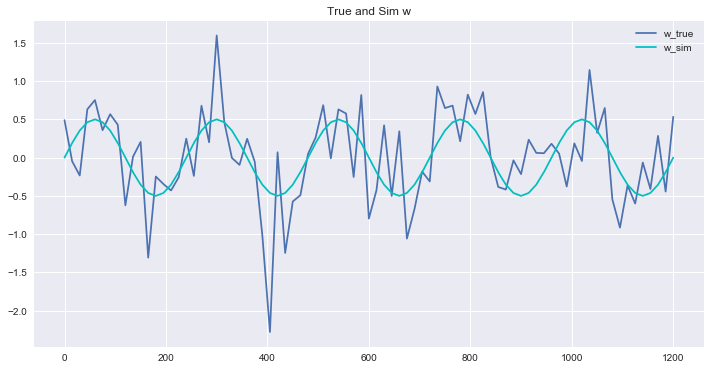

In [8]:
plt.figure(figsize = (12, 6))
plt.plot(w_true[:,1], label = 'w_true')
plt.plot(w_sim[:,1], color = 'c', label = 'w_sim')
plt.title("True and Sim w")
plt.legend(loc = 'best')
plt.show()

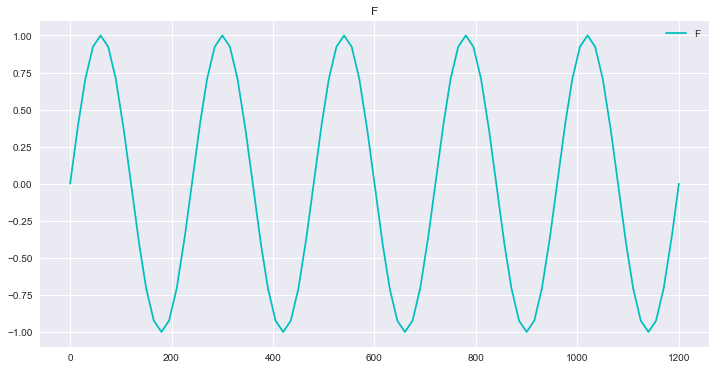

In [9]:
plt.figure(figsize = (12, 6))
plt.plot(F, color = 'c', label = 'F')
plt.title("F")
plt.legend(loc = 'best')
plt.show()

In [10]:
# 観測値，真値，単純シミュレーション値生成
C_true, C_obs = Generate_true_observation(C_init, u, nu, w_true, dx, dt, T, obs_sd)
C_sim = Generate_true_observation(C_init, u, nu, w_sim, dx, dt, T, obs_sd, False)

In [11]:
print(C_obs[375, 16:31:2])

[  6.66262357   3.32659847 -18.72462034  -7.61256015   2.40426499
  11.3770738   -6.54503206  16.96225577]


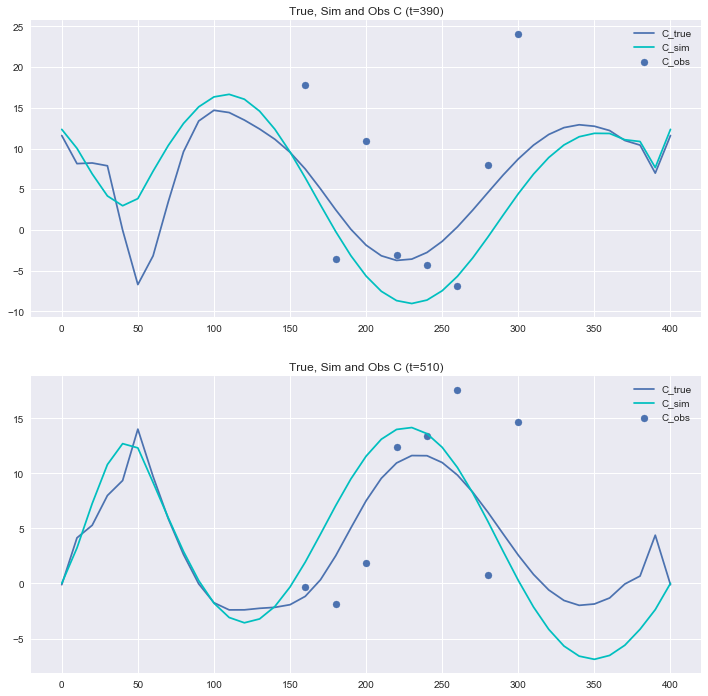

In [12]:
plt.figure(figsize = (12, 12))
plt.subplot(2, 1, 1)
plt.scatter(range(160, 301, 20), C_obs[390, 16:31:2], label = 'C_obs')
plt.plot(range(0, 401, 10), C_true[390], label = 'C_true')
plt.plot(range(0, 401, 10), C_sim[390], color = 'c', label = 'C_sim')
plt.title("True, Sim and Obs C (t=390)")
plt.legend(loc = 'best')

plt.subplot(2, 1, 2)
plt.scatter(range(160, 301, 20), C_obs[510, 16:31:2], label = 'C_obs')
plt.plot(range(0, 401, 10), C_true[510], label = 'C_true')
plt.plot(range(0, 401, 10), C_sim[510], color = 'c', label = 'C_sim')
plt.title("True, Sim and Obs C (t=510)")
plt.legend(loc = 'best')

plt.show()

In [13]:
# パラメータセットの準備
t0 = 360
t1 = 601

update_param = np.array([[u, nu, dx, dt], W])
ad_eval_bg = np.array([C_sim[t0], F[t0:t1]])
ad_param = np.array([[u, nu, dx, dt, obs_sd, true_sd, obs_sd], W])
eval_param = np.array([obs_sd, true_sd, obs_sd])

In [14]:
update_param[0][0]

2.0

In [30]:
n_epoch = 50

In [41]:
am = Adjoint_Method(C_obs[t0:t1], n_epoch, alpha, C_sim[t0], F[t0:t1], update_param, ad_eval_bg, ad_param, eval_param, 
                   evaluation_function, model_update_function, adjoint_update_function)
am.simulate()

 epoch : 50 / 50

### 結果の表示

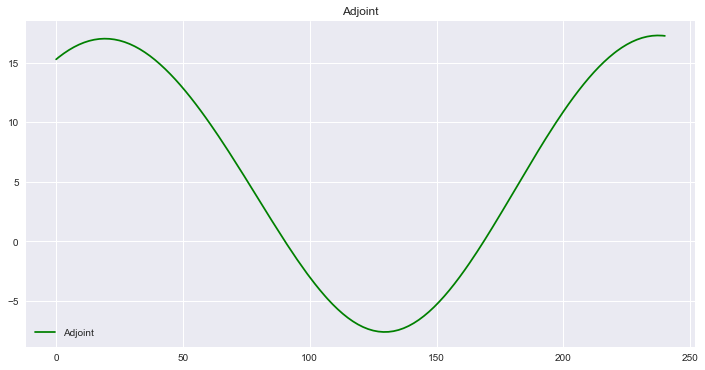

In [42]:
plt.figure(figsize = (12, 6))
plt.plot(am.get_adjoint_value()[:, 10], color = 'g', label = 'Adjoint')
plt.title("Adjoint")
plt.legend(loc = 'best')
plt.show()

- L (空間の長さ)と T (時系列の長さ)をアジョイントクラス内で取り違えているというミス発覚

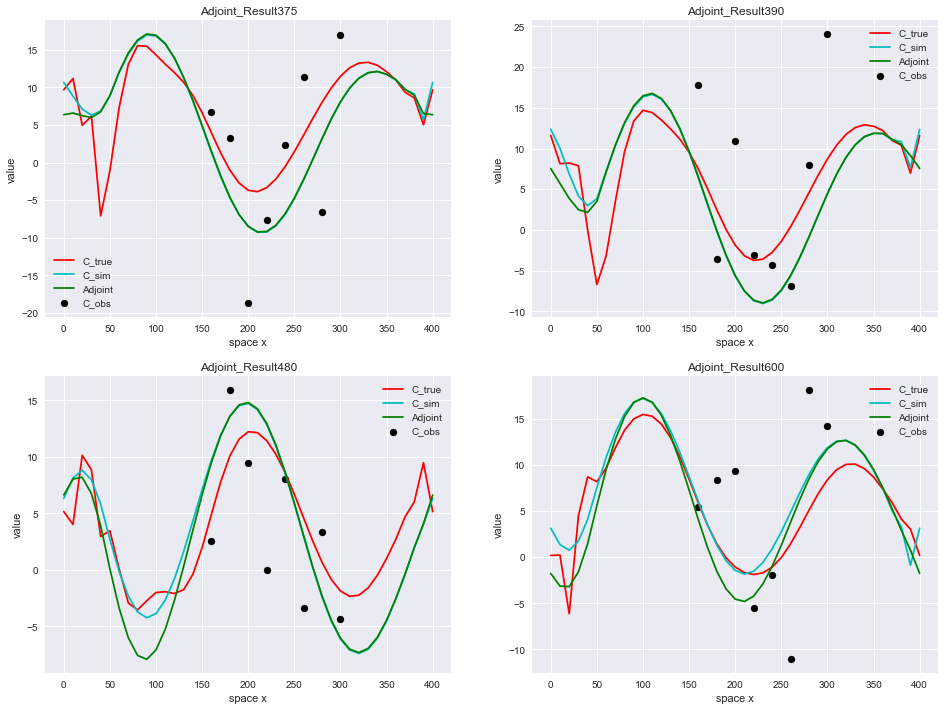

In [43]:
xlim = range(0, 401, 10)
obs_xlim = range(160, 301, 20)
num = [375, 390, 480, 600]

plt.figure(figsize=(16, 12))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.scatter(obs_xlim, C_obs[num[i], 16:31:2], color = 'k', label = 'C_obs')
    plt.plot(xlim, C_true[num[i]], color = 'r', label = 'C_true')
    plt.plot(xlim, C_sim[num[i]], color = 'c', label = 'C_sim')
    plt.plot(xlim, am.get_adjoint_value()[num[i] - t0], color = 'g', label = 'Adjoint')
    plt.legend(loc = 'best')
    plt.xlabel('space x')
    plt.ylabel('value')
    plt.title('Adjoint_Result' +  str(num[i]))

plt.savefig("../plot/180121_Adjoint_concentration_epoch50.png")
plt.show()

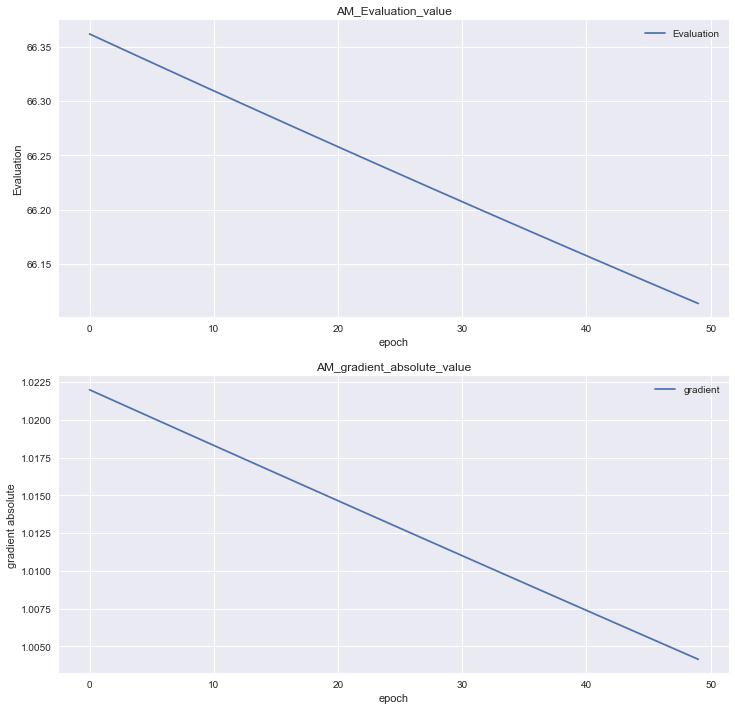

In [44]:
plt.figure(figsize = (12, 12))

plt.subplot(2, 1, 1)
plt.plot(am.get_evaluation_value(), label = 'Evaluation')
plt.legend(loc = 'best')
plt.xlabel('epoch')
plt.ylabel('Evaluation')
plt.title("AM_Evaluation_value")

plt.subplot(2, 1, 2)
plt.plot(am.get_gradient_absolute_value(), label = 'gradient')
plt.legend(loc = 'best')
plt.xlabel('epoch')
plt.ylabel('gradient absolute')
plt.title("AM_gradient_absolute_value")

plt.savefig("../plot/180121_AM_evaluation_gradient_absolute_epoch50.png")
plt.show()

- epoch 1000 で回すと評価関数が途中から上昇するという怪奇現象
- 大変線形に減少．大して減少していない

### 結果の評価(MSE, RMSE)

In [48]:
mse = MSE(C_true[390], am.get_adjoint_value()[390-t0])
df_mse = pd.DataFrame(mse, index = ['Adjoint Method'], columns = ['390'])
df_mse

,390
Adjoint Method,17.986366


In [49]:
rmse = np.sqrt(mse)
df_rmse = pd.DataFrame(rmse, index = ['Adjoint Method'], columns = ['390'])
df_rmse

,390
Adjoint Method,4.241034


### 考察・感想

- x[1]のセットアップに前進差分を用いたら，ギザギザは消失した．
- L と T をアジョイント関数内で取り間違えていたのを修正したら，途中で0に収束する減少は消えた．
- ただ文献(3.706)に比べ，RMS誤差が高い．
    - 文献は，アジョイント法C(840 step, 外力修正)であるが，今回のシミュレーションは違うためか．
    - 文献は準ニュートン法であるが，今回は勾配降下法で行ったためか．
    - 文献では，「リープフロッグスキームの数値的不安定性を防ぐため，15回に1回前進差分を適用する」と述べているが，何に前進差分を適用するのか分からず適用していないためか．
    - 文献で，x[1], ad[T-1]をどうやって計算するか記載がないため，それをてきとーに前進差分で解決したとみなしたためか．